# このnotebookについて

# 事前準備

In [30]:
import os
import json

import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

In [31]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader, HDF5Writer
from modules.data_format.Lattice import Lattice

In [32]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})

# 読み込み先の設定

## 選んだRunを読み込み

In [33]:
# runの読み込み
# Run Selectorで選択したことを想定する
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

In [34]:
selected_run_setting

{'data_root_path': '/Users/ishizawaosamu/work/MasterThesis/data',
 'current_run': 'OIbDia08_2nd',
 'path_to_run_files': '/Users/ishizawaosamu/work/MasterThesis/data/BDD/OIbDia08/2nd',
 'selected_files': {'Temperature': {'raw_radiation': 'OIbDia08_ 04.spe',
   'dist': 'OIbDia08_ 04_separate_half_p45e-2_dist.hdf'},
  'XRD': {'data': 'OIbDia08_4_00000.nxs',
   'calibration': 'pyFAI_calib2_MgS400_CeO2_240511.poni'}},
 'is_overwritten': False,
 'save_root_path': '/Users/ishizawaosamu/work/MasterThesis/save'}

## processed.hdfを読み込み

In [35]:
# up
up_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_up_processed.hdf'
))

# down
down_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_down_processed.hdf'
))

up_hdf.path_list

HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_down_processed.hdf


['entry/measured/error/T',
 'entry/measured/value/T',
 'entry/measured/value/frame_T',
 'entry/measured/value/frame_XRD',
 'entry/measured/value/max_position_T',
 'entry/measured/value/pattern',
 'entry/measured/value/tth',
 'entry/params/frame/T',
 'entry/params/frame/XRD',
 'entry/params/framerate/T',
 'entry/params/framerate/XRD',
 'entry/params/x-ray_wavelength',
 'entry/pwlf_fitting/segment_2/RSS',
 'entry/pwlf_fitting/segment_2/breakpoints_x',
 'entry/pwlf_fitting/segment_2/breakpoints_y',
 'entry/pwlf_fitting/segment_2/intercepts',
 'entry/pwlf_fitting/segment_2/slopes',
 'entry/pwlf_fitting/segment_3/RSS',
 'entry/pwlf_fitting/segment_3/breakpoints_x',
 'entry/pwlf_fitting/segment_3/breakpoints_y',
 'entry/pwlf_fitting/segment_3/intercepts',
 'entry/pwlf_fitting/segment_3/slopes',
 'entry/pwlf_fitting/segment_4/RSS',
 'entry/pwlf_fitting/segment_4/breakpoints_x',
 'entry/pwlf_fitting/segment_4/breakpoints_y',
 'entry/pwlf_fitting/segment_4/intercepts',
 'entry/pwlf_fitting/segm

# データを取得

In [36]:
# データを取得
tth = up_hdf.find_by(query='tth')
pattern = up_hdf.find_by(query='pattern')

wavelength = up_hdf.find_by(query='wavelength')

「tth」で検索します。
	-> entry/measured/value/tth を返しました。
「pattern」で検索します。
	-> entry/measured/value/pattern を返しました。
「wavelength」で検索します。
	-> entry/params/x-ray_wavelength を返しました。


# メソッド定義

In [37]:
def pseudo_voigt(x, x0, amplitude, fwhm, eta):
    """
    Pseudo-Voigt関数
    x: 独立変数 (2θ配列)
    x0: ピーク位置
    amplitude: 強度のスケール
    fwhm: 半値幅 (Full Width at Half Maximum)
    eta: LorentzianとGaussianの比率 (0 <= eta <= 1)
    """
    gaussian = amplitude * np.exp(-4 * np.log(2) * ((x - x0) / fwhm) ** 2)
    lorentzian = amplitude / (1 + ((x - x0) / (0.5 * fwhm)) ** 2)
    return eta * lorentzian + (1 - eta) * gaussian


In [38]:
def fit_pseudo_voigt(x, y):
    """
    Pseudo-Voigt関数を用いてピークフィッティングを行う

    Parameters:
    x : array-like
        2θ配列
    y : array-like
        強度配列

    Returns:
    peak_position : float
        フィッティングされたピーク位置
    peak_error : float
        ピーク位置の誤差
    """
    # 初期パラメータの推定
    x0_guess = x[np.argmax(y)]
    amplitude_guess = np.max(y)
    fwhm_guess = (x[-1] - x[0]) / 20  # データ範囲の20分の1に変更
    eta_guess = 0.5  # 固定値

    initial_guess = [x0_guess, amplitude_guess, fwhm_guess, eta_guess]
    bounds = ([x[0], 0, (x[-1] - x[0]) / 100, 0], [x[-1], np.inf, (x[-1] - x[0]) / 2, 1])  # fwhmの下限を狭める

    try:
        popt, pcov = curve_fit(pseudo_voigt, x, y, p0=initial_guess, bounds=bounds)
        x0, amplitude, fwhm, eta = popt
        errors = np.sqrt(np.diag(pcov))
        peak_error = errors[0] if len(errors) > 0 else None
        return x0, peak_error
    except Exception as e:
        print(f"フィッティングエラー: {e}")
        return None, None


In [39]:
# 配列と値を渡したら、値に最も近いindexを返す関数
def return_idx(arr, *values):
    idxs = tuple(int((np.abs(arr - value)).argmin()) for value in values)
    # valuesが1つであればタプルではなく単独の値を返す
    return idxs[0] if len(idxs) == 1 else idxs


In [40]:
def get_argmax_tth_in_area(
        from_tth=None,
        to_tth=None,
        tth=tth,
        pattern=pattern,
):
    from_tth_idx, to_tth_idx = return_idx(tth, from_tth, to_tth)
    # 最大値をとるindexを取得
    peak_pos = np.argmax(pattern[:,     from_tth_idx:to_tth_idx], axis=1) + (from_tth_idx     + 1)  # 範囲を制限した中でのindex
    # ↑のindexからtthを取得。numpy.ndarrayなので、これで配    列として変換される
    peak_tth = tth[peak_pos]
    return peak_tth


In [41]:
def fit_peaks_in_area(tth=tth, pattern=pattern, from_tth=None, to_tth=None):
    """
    指定範囲内のピークをPseudo-Voigtでフィッティングし、結果を格納する。

    Parameters:
    tth : numpy.ndarray
        2θ配列
    pattern : numpy.ndarray
        強度パターン
    from_tth : float
        フィッティング範囲の開始角度
    to_tth : float
        フィッティング範囲の終了角度

    Returns:
    peak_positions : numpy.ndarray
        フィッティングされたピーク位置の配列
    peak_errors : numpy.ndarray
        ピーク位置の誤差の配列
    """
    peak_tths = get_argmax_tth_in_area(from_tth, to_tth, tth, pattern)
    peak_positions = []
    peak_errors = []

    for i, peak_tth in tqdm(enumerate(peak_tths)):
        # フィッティング範囲を設定
        fit_range = (tth >= peak_tth - 0.5) & (tth <= peak_tth + 0.5)
        x_fit = tth[fit_range]
        y_fit = pattern[i, fit_range]

        if len(x_fit) > 3:  # フィッティング可能なデータポイントが十分ある場合のみ実行
            peak_position, peak_error = fit_pseudo_voigt(x_fit, y_fit)
            peak_positions.append(peak_position)
            peak_errors.append(peak_error)
        else:
            peak_positions.append(None)
            peak_errors.append(None)

    return np.array(peak_positions), np.array(peak_errors)


# ピークを設定

In [42]:
# 体積を計算するときのインスタンス
lattice = Lattice(wavelength_m=wavelength)# 図示して確認

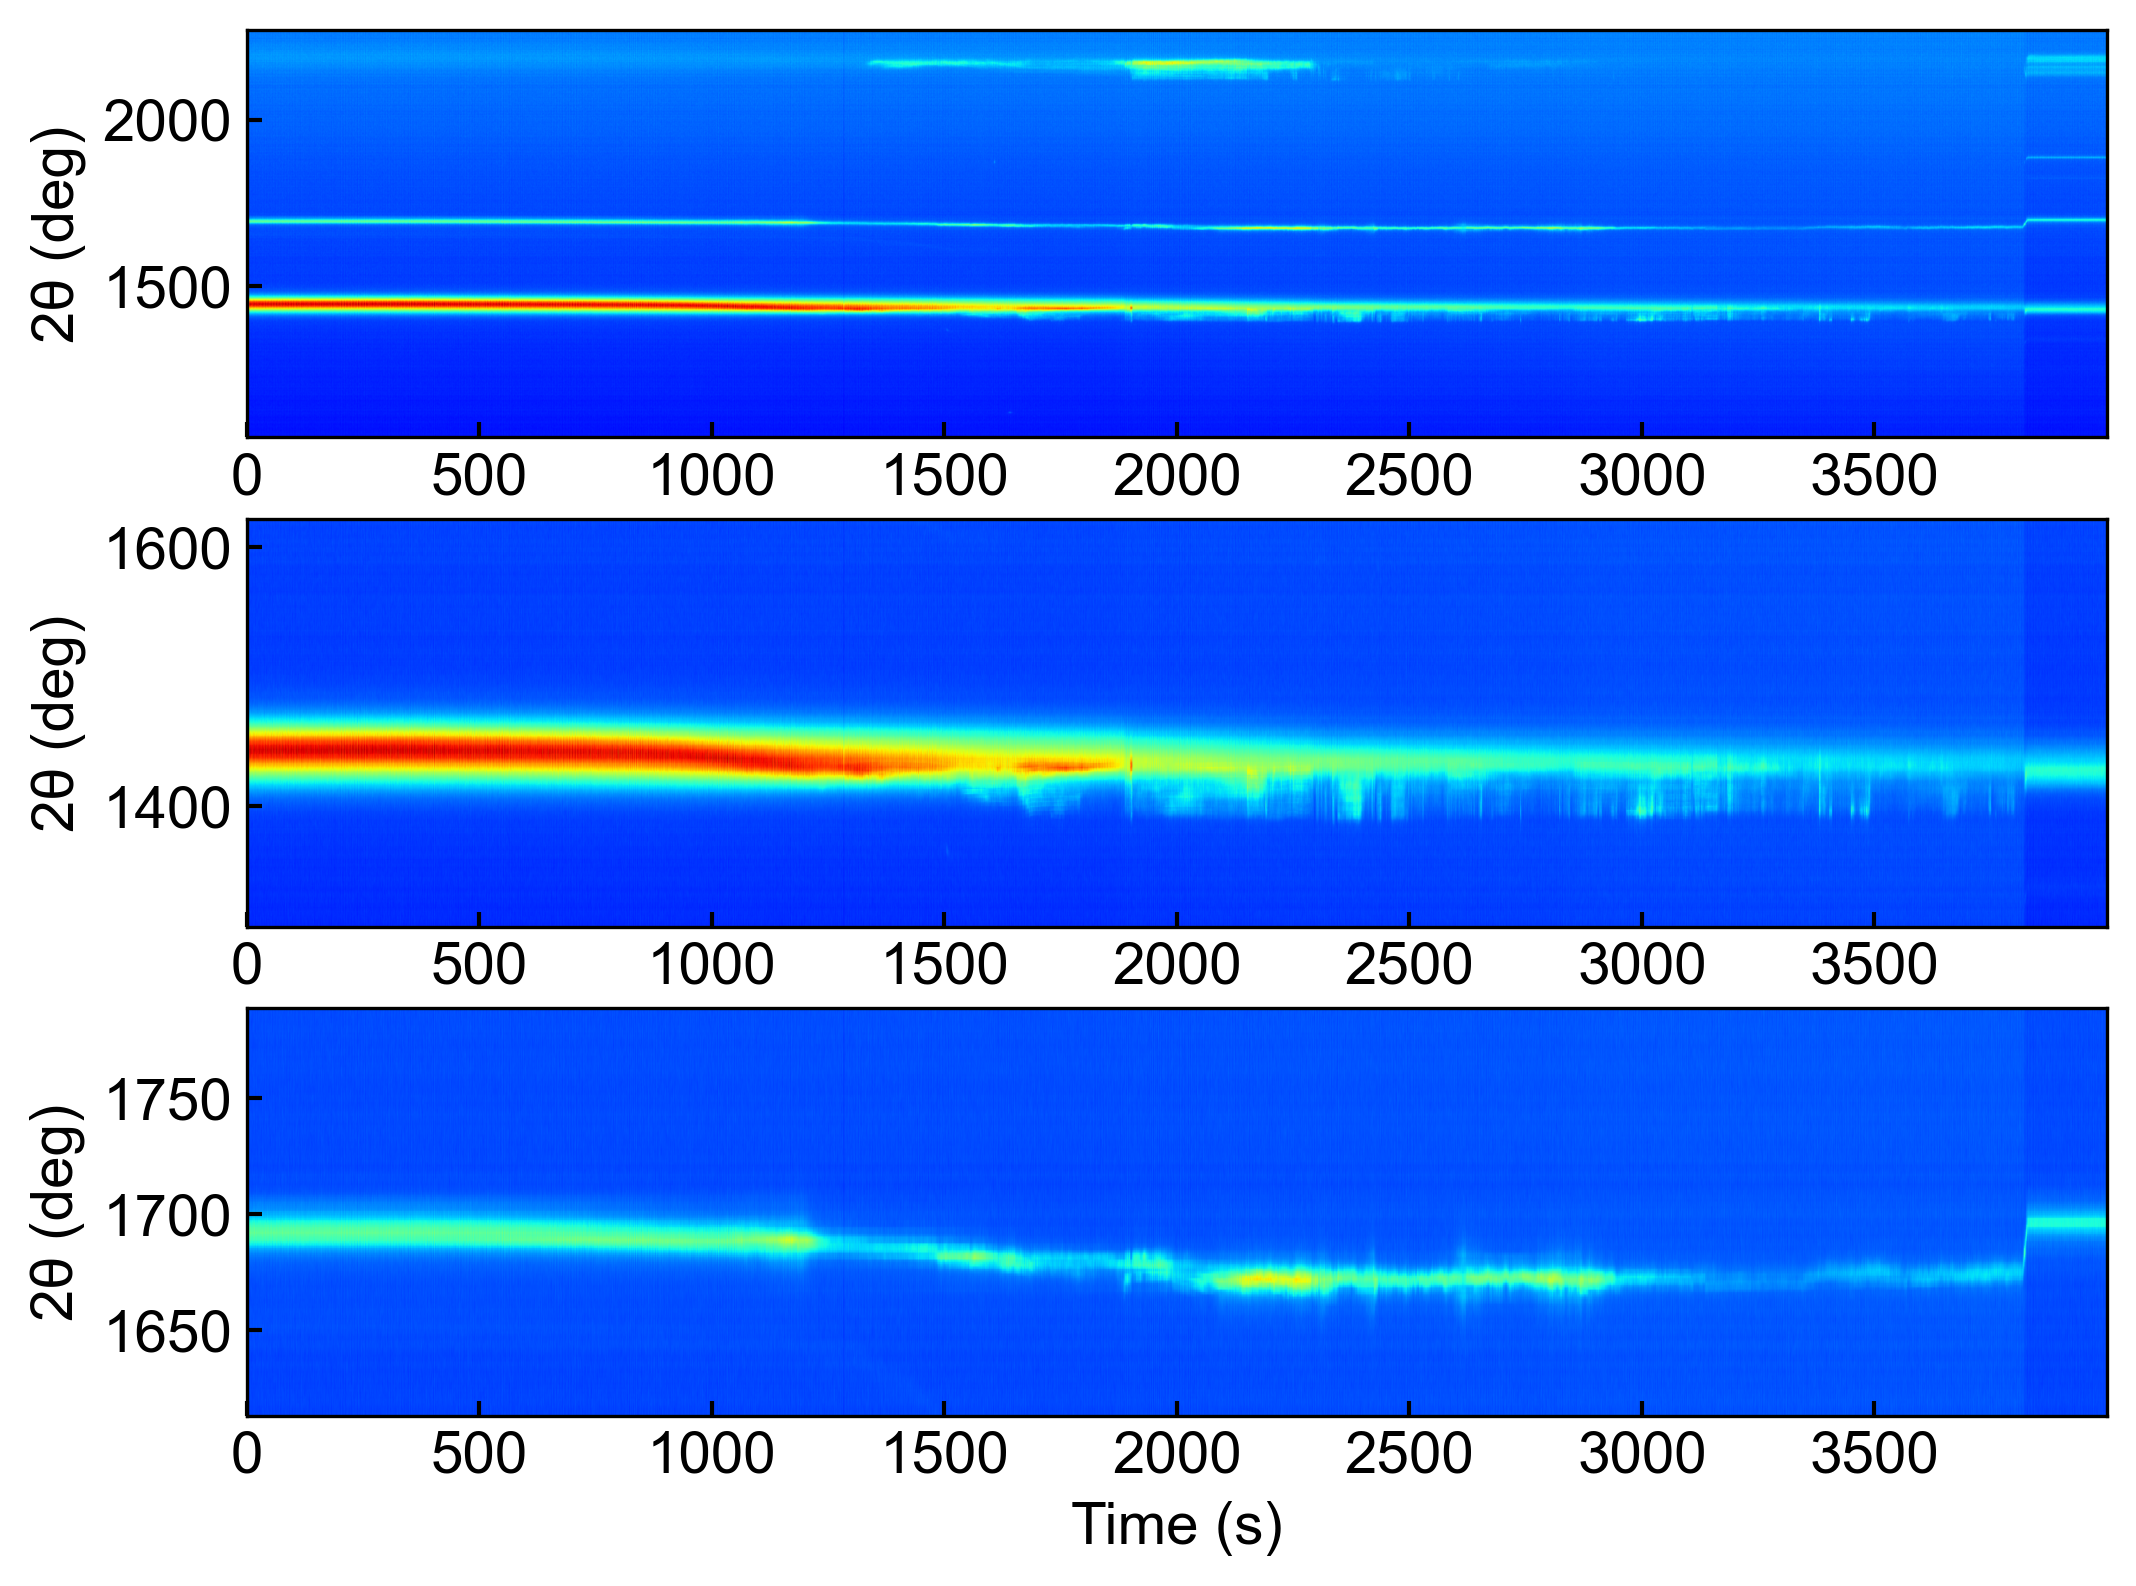

In [43]:
kcl_from_tth = 9.5
kcl_to_tth = 11.3
dia_from_tth = 11.25
dia_to_tth = 12.25
kcl_from_tth_idx, kcl_to_tth_idx, dia_from_tth_idx, dia_to_tth_idx = return_idx(tth, kcl_from_tth, kcl_to_tth, dia_from_tth, dia_to_tth)

fig, axes = plt.subplots(3, 1)
ax = axes[0]
ax.imshow(pattern.T, aspect='auto', cmap='jet', origin='upper')
ax.set_ylabel('2θ (deg)')
ax.set_ylim(return_idx(tth, 8), return_idx(tth, 15))

ax = axes[1]
ax.imshow(pattern.T, aspect='auto', cmap='jet', origin='upper')
ax.set_xlabel('Time (s)')
ax.set_ylabel('2θ (deg)')
ax.set_ylim(kcl_from_tth_idx, kcl_to_tth_idx)

ax = axes[2]
ax.imshow(pattern.T, aspect='auto', cmap='jet', origin='upper')
ax.set_xlabel('Time (s)')
ax.set_ylabel('2θ (deg)')
ax.set_ylim(dia_from_tth_idx, dia_to_tth_idx)

plt.show()
plt.close()


## KCl 200

### 範囲設定

In [44]:
kcl_from_tth = 9.5
kcl_to_tth = 11.3

In [45]:
# current_runによって狭めるとき


### 位置を取得

In [46]:
# まず最大強度の位置の配列を作成
kcl_max_pos_tth_array = get_argmax_tth_in_area(
    from_tth=kcl_from_tth,
    to_tth=kcl_to_tth,
)

### fitting

In [47]:
# フィッティング実行
kcl_peak_positions, kcl_peak_errors = fit_peaks_in_area(from_tth=kcl_from_tth, to_tth=kcl_to_tth)

4000it [00:11, 362.31it/s]


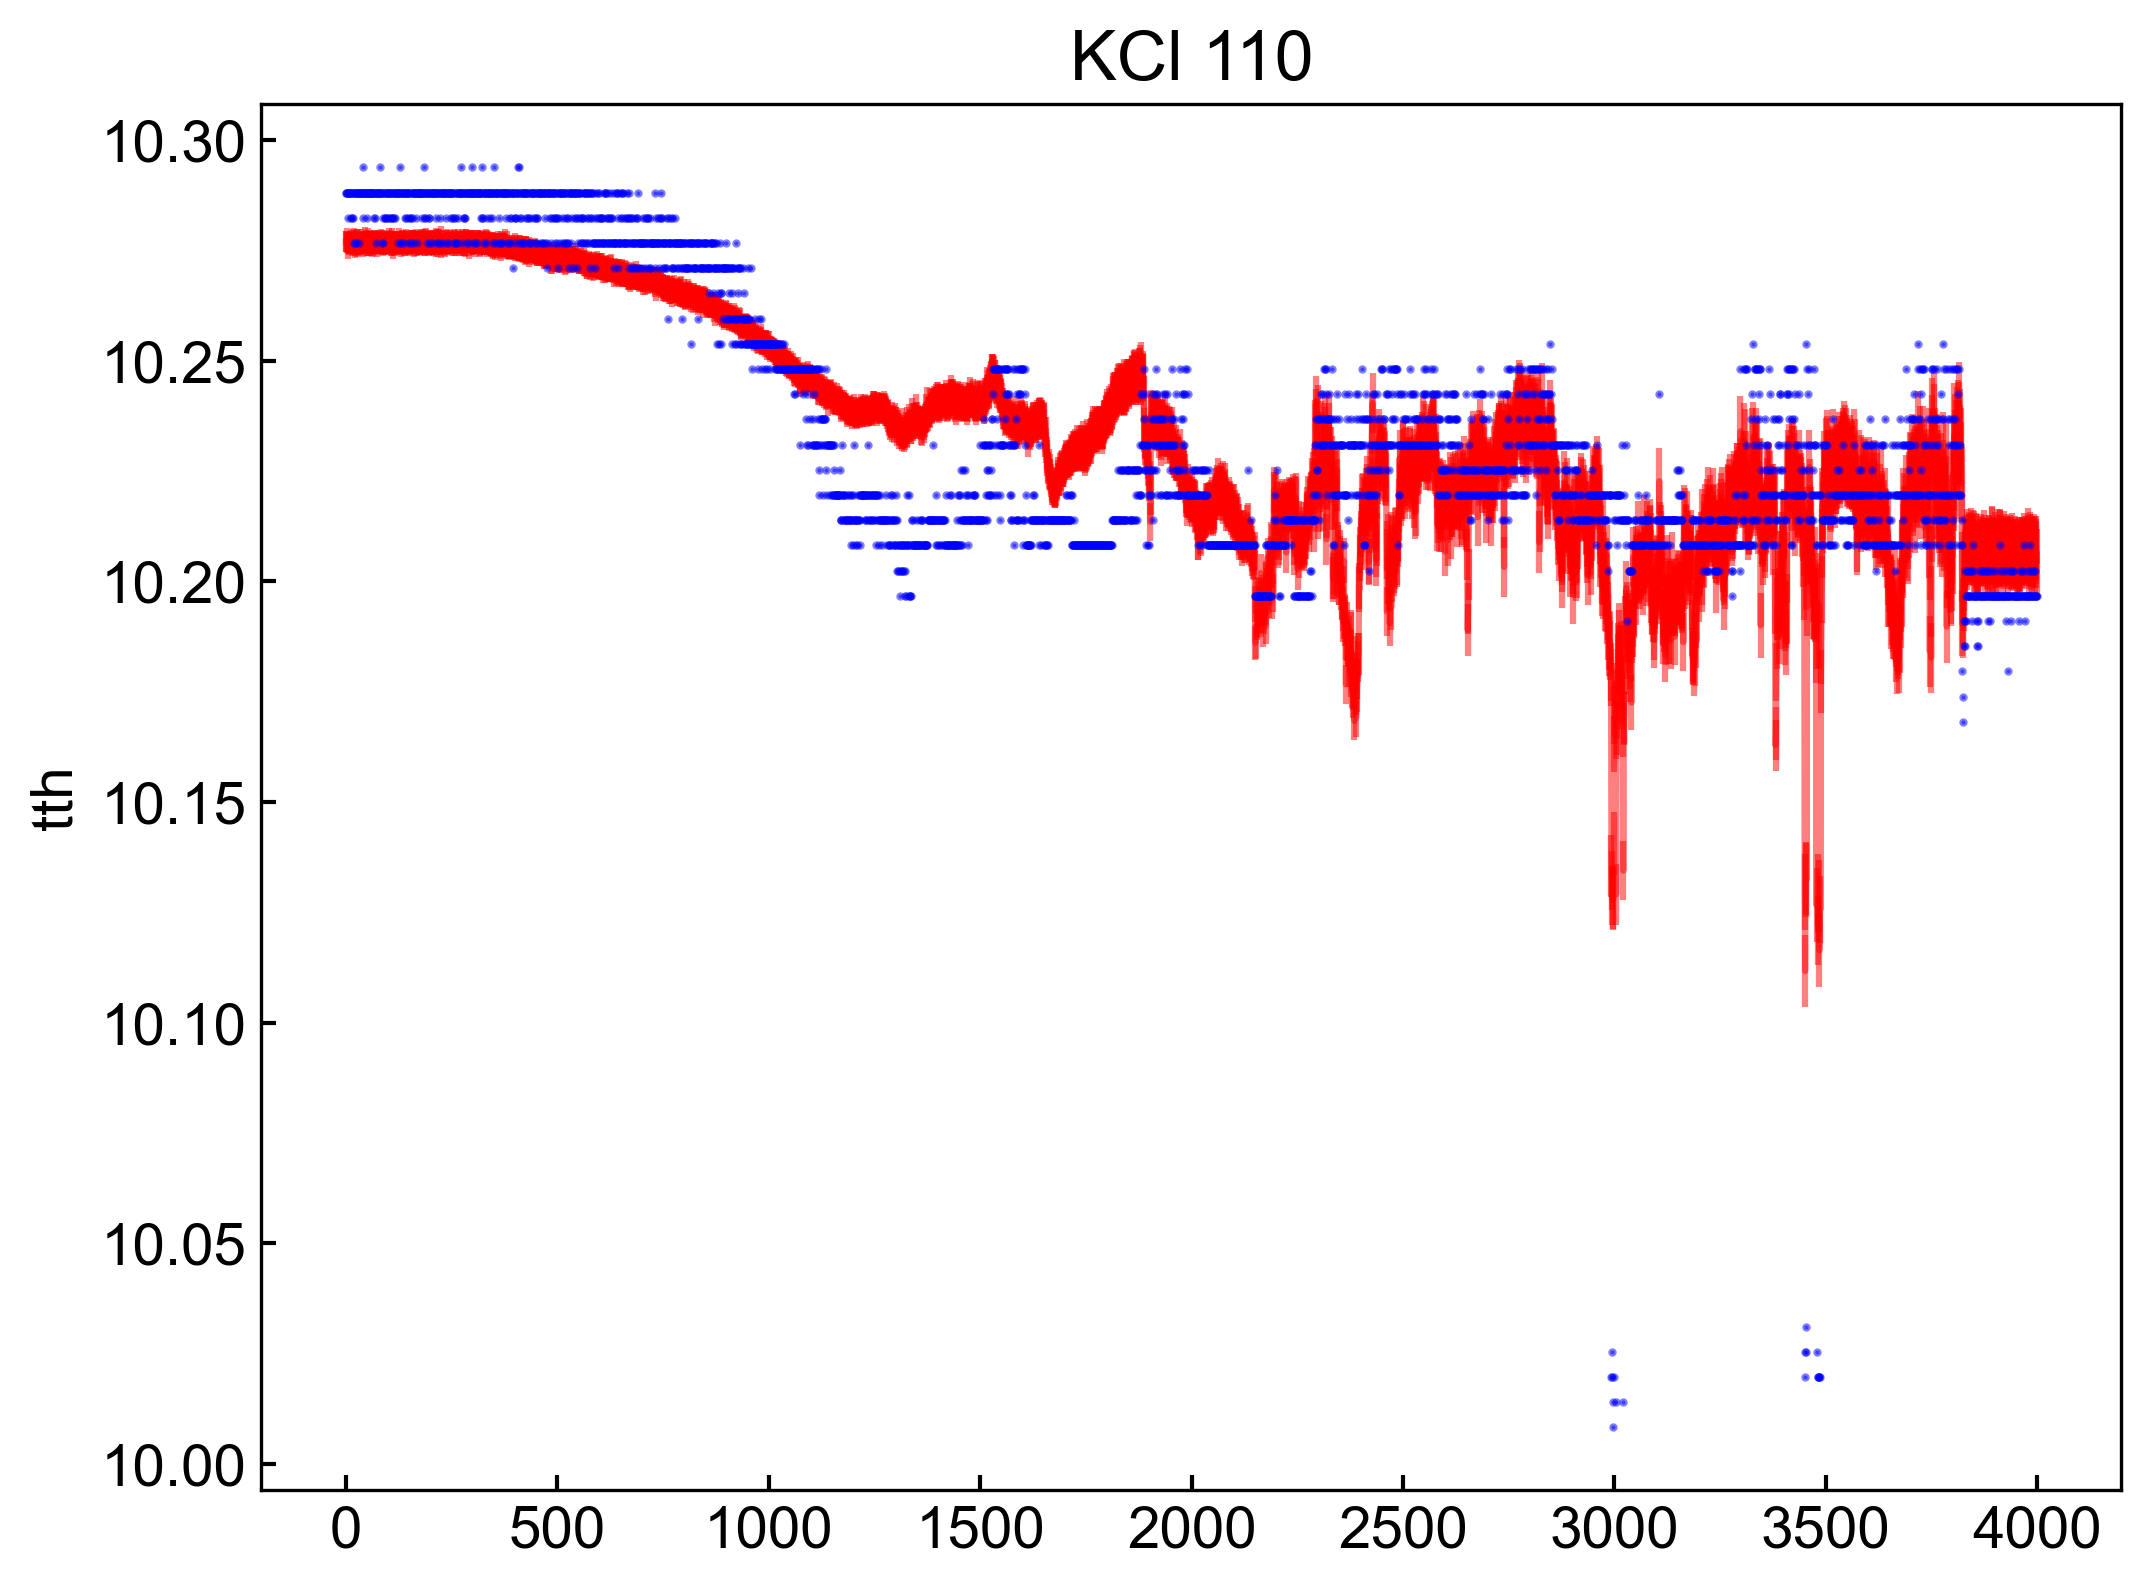

In [48]:
# 比較
plt.errorbar(np.arange(len(kcl_peak_positions)), kcl_peak_positions, yerr=kcl_peak_errors, color='red', alpha=0.5, ms=1, label='fitted position')
plt.scatter(np.arange(len(kcl_max_pos_tth_array)), kcl_max_pos_tth_array, color='blue', alpha=0.5, s=1, label='max-position', zorder=10)
plt.title('KCl 110')
plt.ylabel('tth')
plt.show()
plt.close()

### 最大位置、fittingの位置と幅

In [49]:
kcl_fitted_V = lattice.calc_KCl110_V_from_tth(kcl_peak_positions)
kcl_fitted_V_max = lattice.calc_KCl110_V_from_tth(kcl_peak_positions - kcl_peak_errors)
kcl_fitted_V_min = lattice.calc_KCl110_V_from_tth(kcl_peak_positions + kcl_peak_errors)
kcl_pos_V = lattice.calc_KCl110_V_from_tth(kcl_max_pos_tth_array)

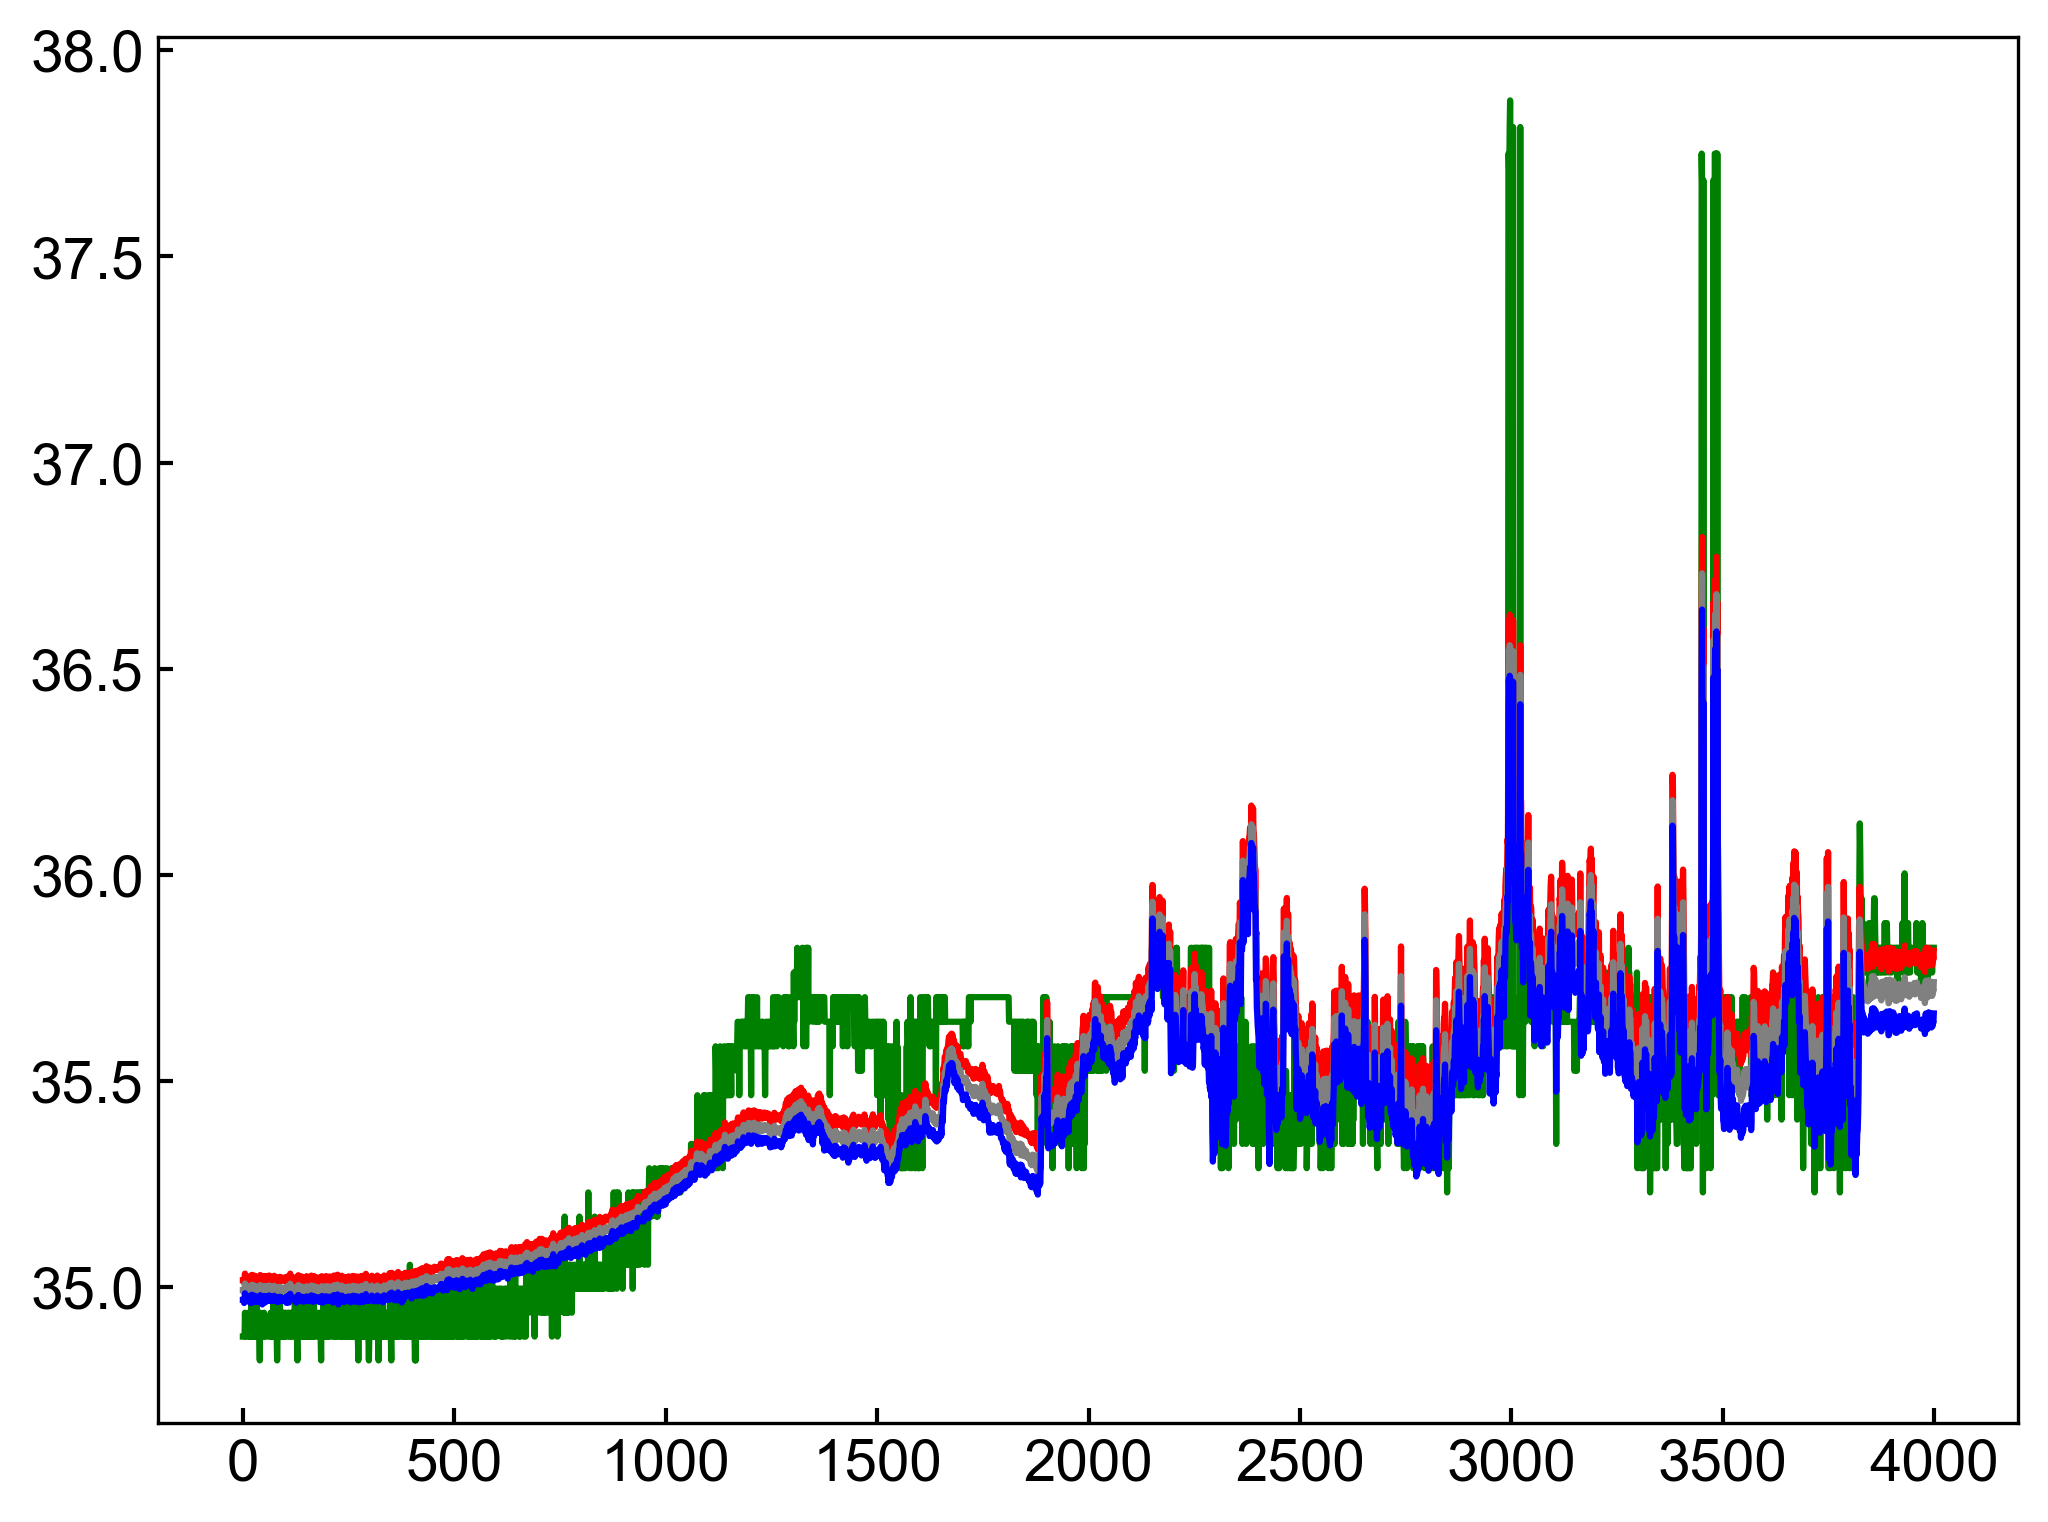

In [50]:
plt.plot(kcl_pos_V, color='green')
plt.plot(kcl_fitted_V_max, color='red')
plt.plot(kcl_fitted_V, color='gray')
plt.plot(kcl_fitted_V_min, color='blue')

## diamond 111

In [51]:
# 基本
dia_from_tth = 11.25
dia_to_tth = 12.25

In [52]:
# 狭める時


In [53]:
# まず最大強度の位置の配列を作成
dia_max_pos_tth_array = get_argmax_tth_in_area(
    from_tth=dia_from_tth,
    to_tth=dia_to_tth,
)
### fitting
# フィッティング実行
dia_peak_positions, dia_peak_errors = fit_peaks_in_area(from_tth=dia_from_tth, to_tth=dia_to_tth)

4000it [00:12, 329.46it/s]


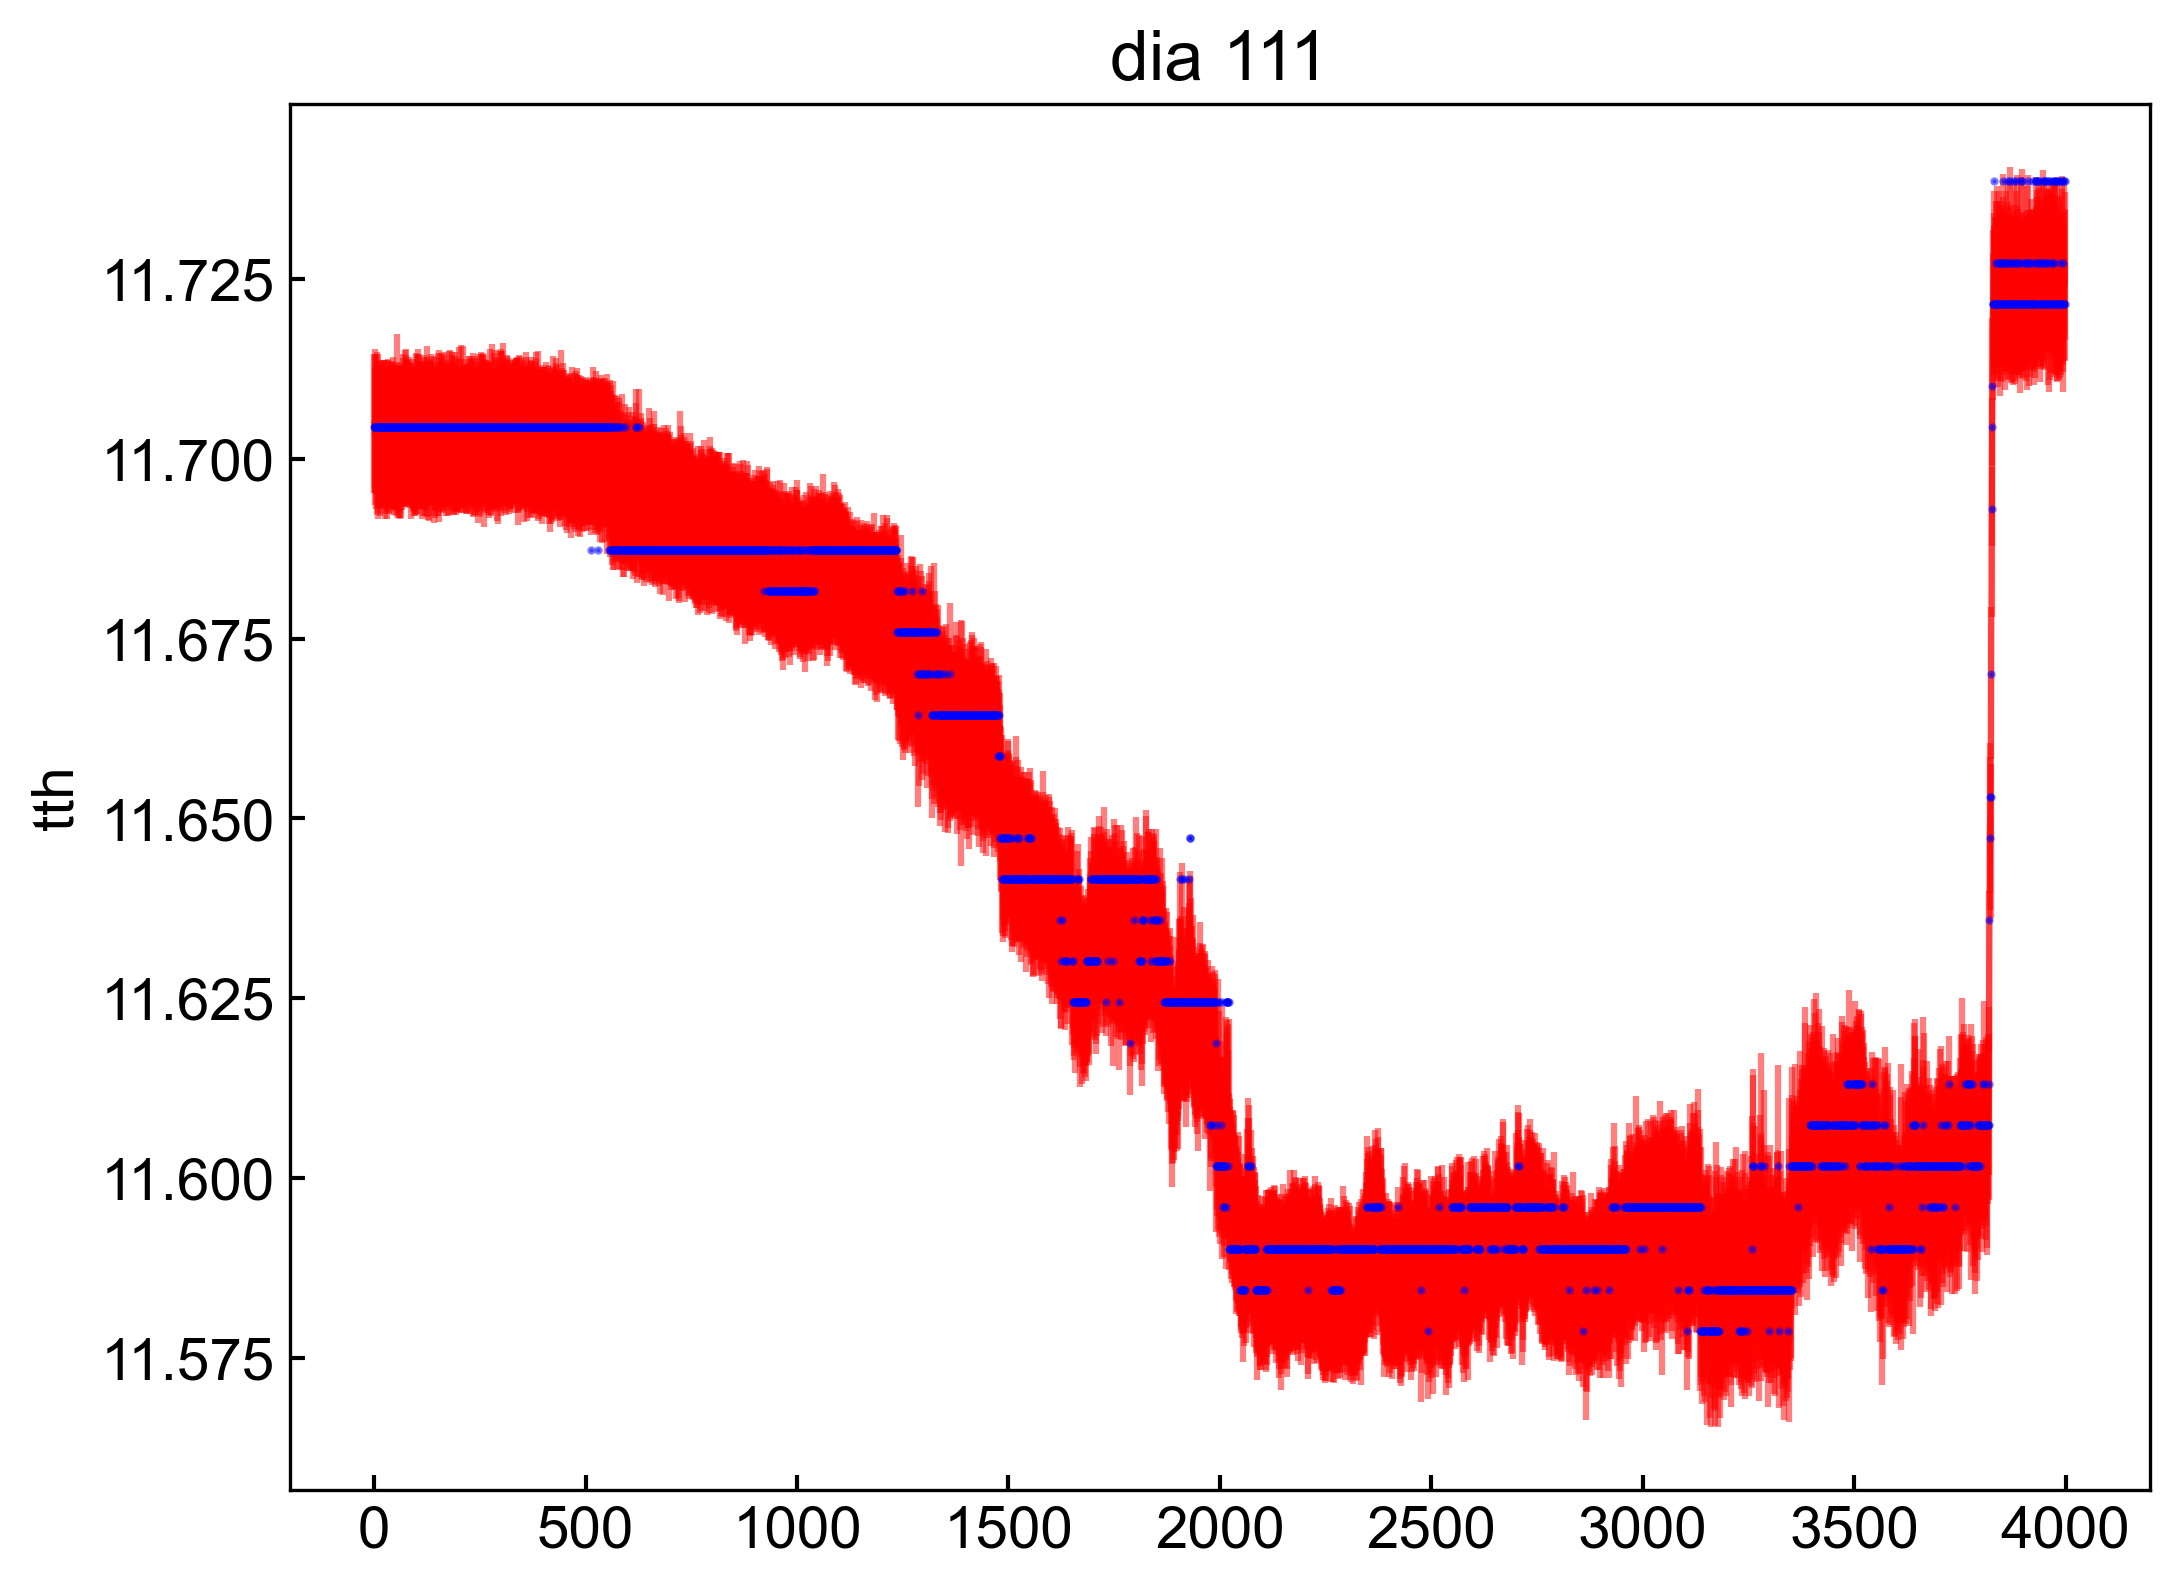

In [54]:
# 比較
plt.errorbar(np.arange(len(dia_peak_positions)), dia_peak_positions, yerr=dia_peak_errors, color='red', alpha=0.5, ms=1,
             label='fitted position')
plt.scatter(np.arange(len(dia_max_pos_tth_array)), dia_max_pos_tth_array, color='blue', alpha=0.5, s=1,
            label='max-position', zorder=10)
plt.title('dia 111')
plt.ylabel('tth')
plt.show()
plt.close()

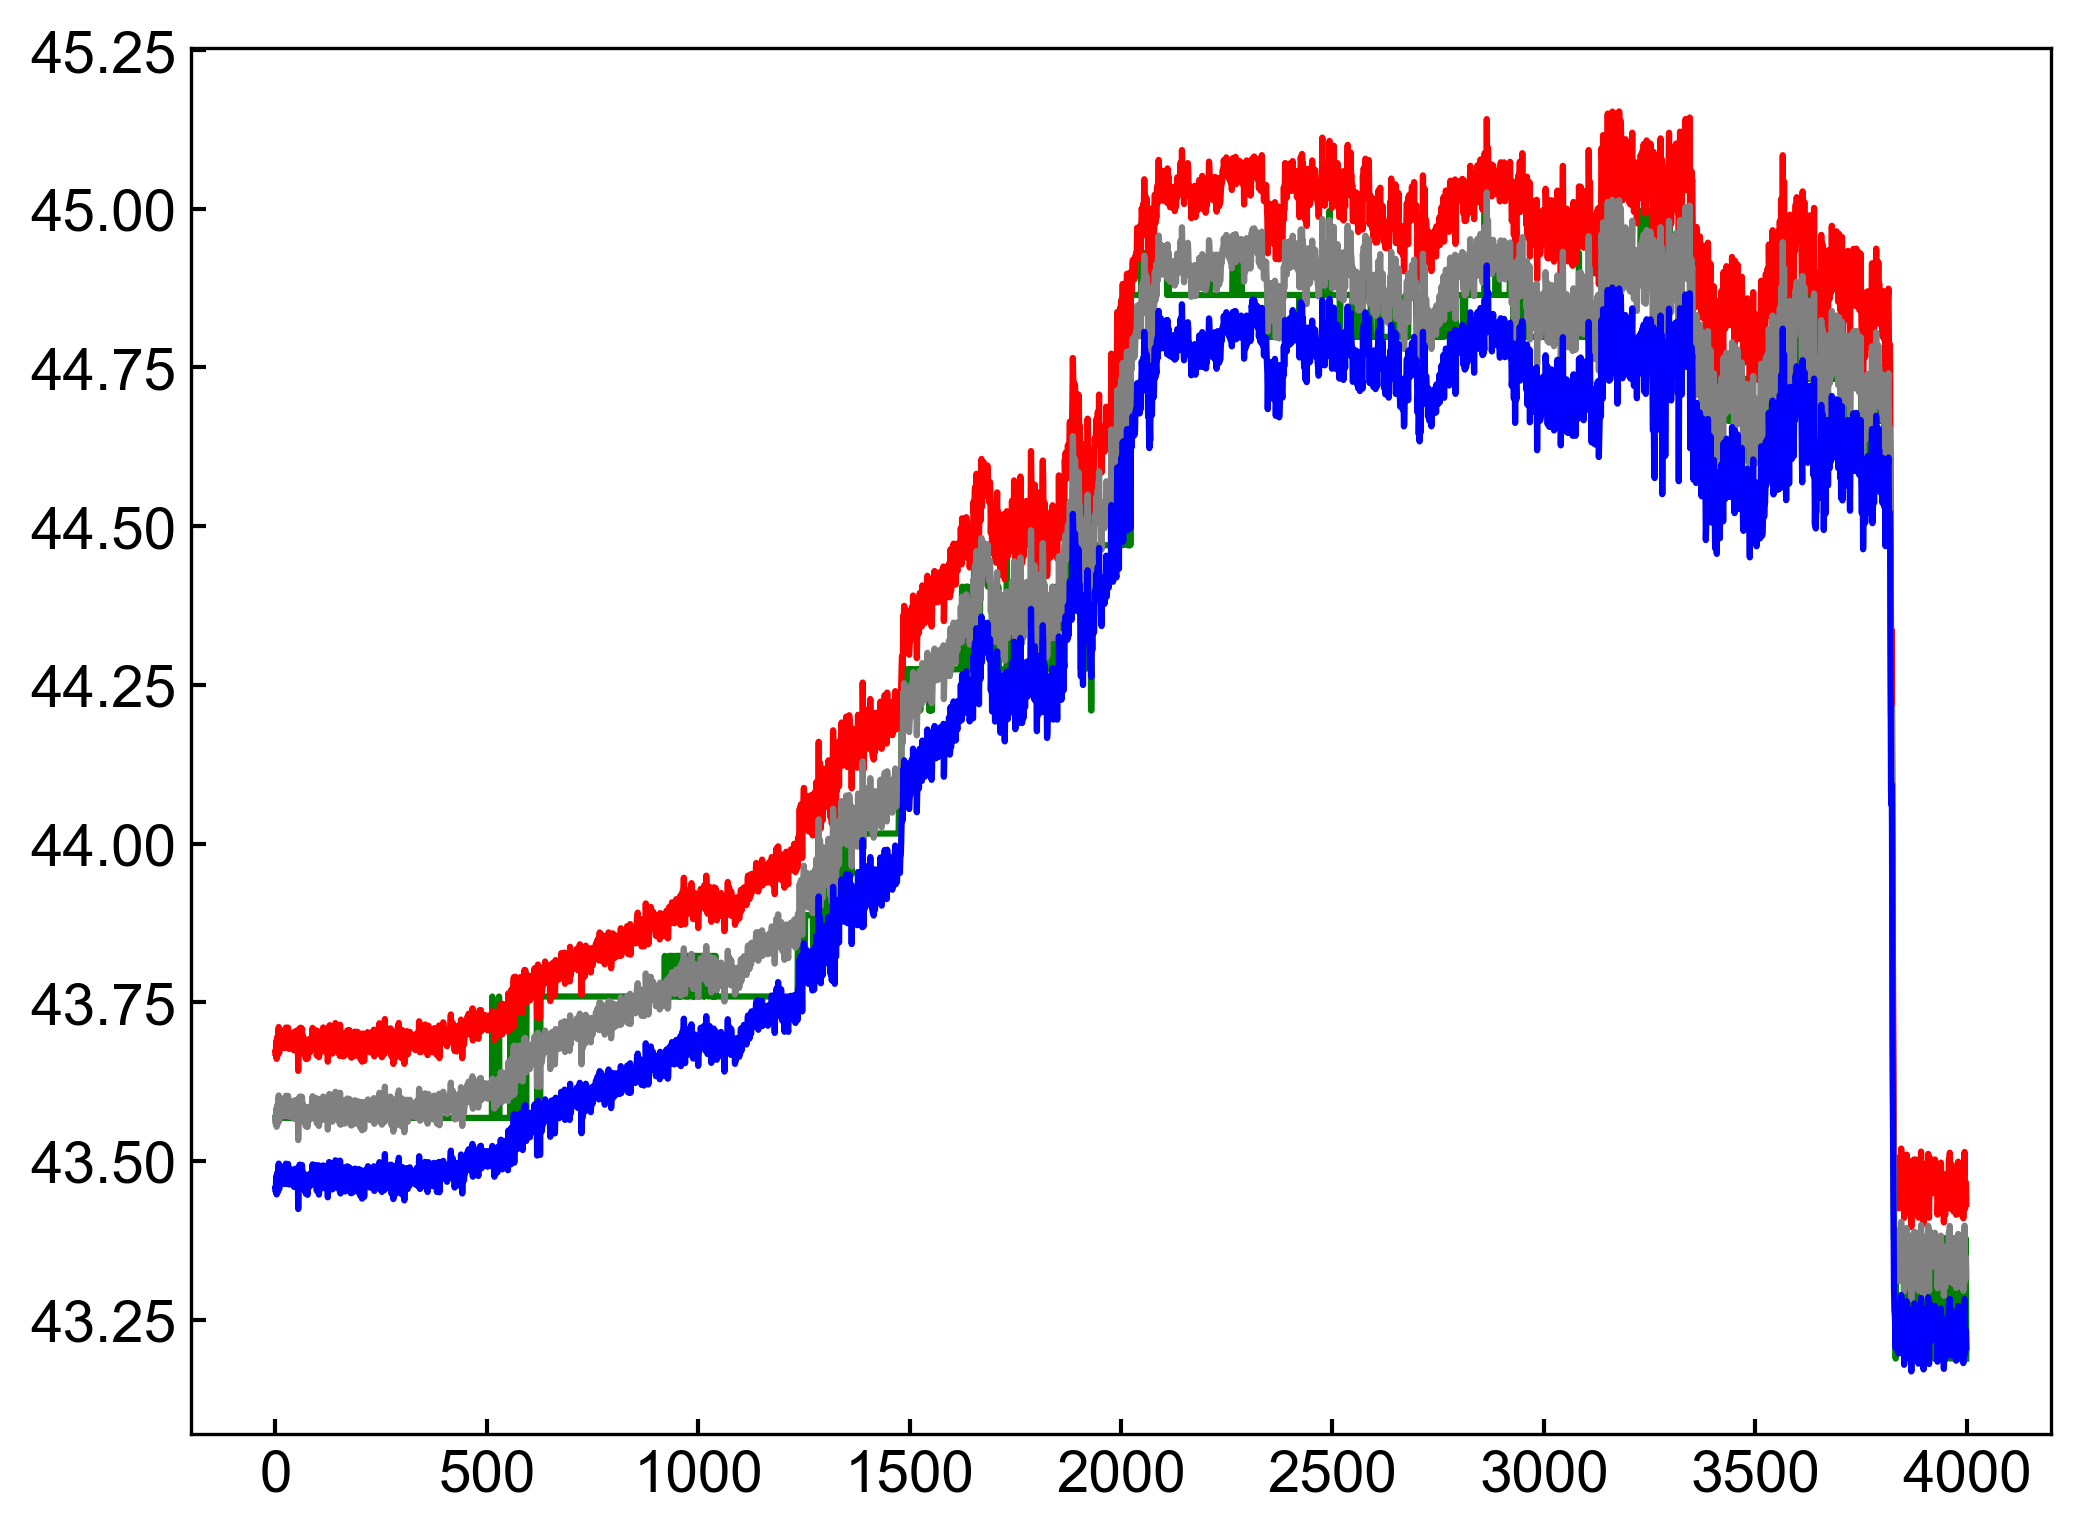

In [55]:
### 最大位置、fittingの位置と幅
dia_fitted_V = lattice.calc_Diamond111_V_from_tth(dia_peak_positions)
dia_fitted_V_max = lattice.calc_Diamond111_V_from_tth(dia_peak_positions - dia_peak_errors)
dia_fitted_V_min = lattice.calc_Diamond111_V_from_tth(dia_peak_positions + dia_peak_errors)
dia_pos_V = lattice.calc_Diamond111_V_from_tth(dia_max_pos_tth_array)
plt.plot(dia_pos_V, color='green')
plt.plot(dia_fitted_V_max, color='red')
plt.plot(dia_fitted_V, color='gray')
plt.plot(dia_fitted_V_min, color='blue')

# 保存

In [56]:
# 上書きするかどうかを設定
is_overwritten = selected_run_setting['is_overwritten']
is_overwritten


False

In [57]:
# 書き込み先の設定
# run_name_processed.hdfを作成する。すでにあればそれが読み込まれる
up_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_up_processed.hdf'
    )
)

down_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_down_processed.hdf'
    )
)


HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_down_processed.hdf


In [58]:
# 配列の保存
for saved_hdf in [up_saved_hdf, down_saved_hdf]:
    saved_hdf.write(data_path='entry/measured/kcl110/max_pos_V', data=kcl_pos_V, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/measured/kcl110/fitted_V', data=kcl_fitted_V, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/error/kcl110/fitted_V_max', data=kcl_fitted_V_max, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/error/kcl110/fitted_V_min', data=kcl_fitted_V_min, overwrite=is_overwritten)

    saved_hdf.write(data_path='entry/measured/dia111/max_pos_V', data=dia_pos_V, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/measured/dia111/fitted_V', data=dia_fitted_V, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/error/dia111/fitted_V_max', data=dia_fitted_V_max, overwrite=is_overwritten)
    saved_hdf.write(data_path='entry/error/dia111/fitted_V_min', data=dia_fitted_V_min, overwrite=is_overwritten)



書き込みに成功しました: 'entry/measured/kcl110/max_pos_V' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/measured/kcl110/fitted_V' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/error/kcl110/fitted_V_max' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/error/kcl110/fitted_V_min' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/measured/dia111/max_pos_V' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/measured/dia111/fitted_V' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/error/dia111/fitted_V_max' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_2nd_up_processed.hdf
書き込みに成功しました: 'entry/error/dia111/fit